In [3]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import yfinance as yf


In [15]:
def adjustedMetric(data, model, model_k, yname):
    data["yhat"] = model.predict(data)
    SST = ((data[yname] - data[yname].mean()) ** 2).sum()
    SSR = ((data["yhat"] - data[yname].mean()) ** 2).sum()
    SSE = ((data[yname] - data["yhat"]) ** 2).sum()
    r2 = SSR / SST
    adjustR2 = 1 - (1 - r2) * (data.shape[0] - 1) / (data.shape[0] - model_k - 1)
    RMSE = (SSE / (data.shape[0] - model_k - 1)) ** 0.5
    return adjustR2, RMSE
# Root Mean Squared Error and Adjusted R2
# model_k is the number of predictors
# ynam is the column name of our response variable
# model is the model name here lm


def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=["R2", "RMSE"], columns=["train", "test"])
    assessment["train"] = [r2train, RMSEtrain]
    assessment["test"] = [r2test, RMSEtest]
    return assessment

In [20]:
ticker_universe = ['SPY','^FCHI','^N225','^GDAXI','^HSI','^IXIC','^AORD','^GSPC','^DJI']
fecha_fin_calculo = (datetime.now() - timedelta(days= 1)).strftime('%Y-%m-%d')
fecha_inicio_calculo = '2010-01-01'

spy = yf.download('SPY', start=fecha_inicio_calculo, end=fecha_fin_calculo)
cac40 = yf.download('^FCHI', start=fecha_inicio_calculo, end=fecha_fin_calculo)
nikkei = yf.download('^N225', start=fecha_inicio_calculo, end=fecha_fin_calculo)
daxi = yf.download('^GDAXI', start=fecha_inicio_calculo, end=fecha_fin_calculo)
hsi = yf.download('^HSI', start=fecha_inicio_calculo, end=fecha_fin_calculo)
nasdaq = yf.download('^IXIC', start=fecha_inicio_calculo, end=fecha_fin_calculo)
aord = yf.download('^AORD', start=fecha_inicio_calculo, end=fecha_fin_calculo)
sp500 = yf.download('^GSPC', start=fecha_inicio_calculo, end=fecha_fin_calculo)
dji = yf.download('^DJI', start=fecha_inicio_calculo, end=fecha_fin_calculo)
vix = yf.download('^VIX', start=fecha_inicio_calculo, end=fecha_fin_calculo)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [21]:
#2 Extract the data from each DF into one : We
indicepanel=pd.DataFrame(index=spy.index)

indicepanel['spy']=spy['Open'].shift(-1)-spy['Open'] #response variable
indicepanel['spy_lag1']=indicepanel['spy'].shift(1)
indicepanel['sp500']=sp500["Open"]-sp500['Open'].shift(1)
indicepanel['nasdaq']=nasdaq['Open']-nasdaq['Open'].shift(1)
indicepanel['dji']=dji['Open']-dji['Open'].shift(1)

indicepanel['cac40']=cac40['Open']-cac40['Open'].shift(1)
indicepanel['daxi']=daxi['Open']-daxi['Open'].shift(1)
indicepanel['vix'] = vix['Open'] - vix['Open'].shift(1)

indicepanel['aord']=aord['Open']-aord['Open'].shift(1)
indicepanel['hsi']=hsi['Open']-hsi['Open'].shift(1)
indicepanel['nikkei']=nikkei['Open']-nikkei['Open'].shift(1)
indicepanel['Price']=spy['Open']

In [22]:
#3 get rid of the NaN values
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

In [41]:
#4 let's split the Data set into train and test.

Train = indicepanel.iloc[-600:-250, :]
Test = indicepanel.iloc[-250:, :]
print(Train.shape, Test.shape)

(350, 12) (250, 12)


In [46]:
#5 perform the OLS regression 

formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8232
Date:                Tue, 03 Sep 2024   Prob (F-statistic):              0.595
Time:                        17:59:22   Log-Likelihood:                -1061.9
No. Observations:                 350   AIC:                             2144.
Df Residuals:                     340   BIC:                             2182.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0105      0.274     -0.038      0.970      -0.550       0.529
spy_lag1       0.1284      0.306      0.419      0.675      -0.474       0.731
sp500         -0.0517      0.044     -1.172      0.242      -0.138       0.035
nasdaq         0.0055      0.007      0.785      0.433      -0.008       0.019
dji            0.0020      0.003      0.614      0.540      -0.004       0.008
cac40          0.0182      0.010      1.778      0.076      -0.002       0.038
aord           0.0036      0.004      0.833      0.405      -0.005       0.012
daxi          -0.0092      0.005     -1.939      0.053      -0.019       0.000
nikkei         0.0017      0.001      1.398      0.163      -0.001       0.004
hsi         9.679e-05      0.001      0.106      0.916      -0.002       0.002
==============================================================================
Omnibus:                       10.029   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               15.806
Skew:                          -0.171   Prob(JB):                     0.000370
Kurtosis:                       3.983   Cond. No.                         502.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

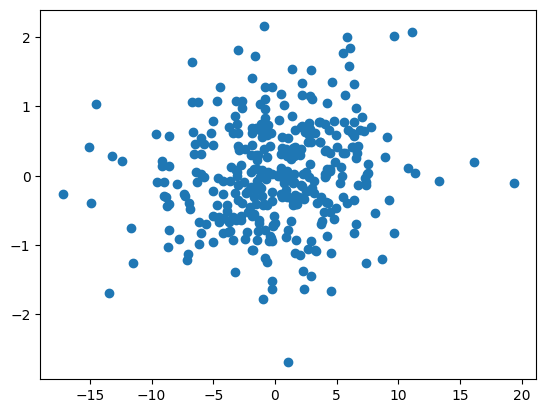

In [47]:
#6 Prediction 

Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)
plt.scatter(Train['spy'], Train['PredictedY'])

In [48]:
#7 check statistical validity
assessTable(Test, Train, lm, 9, 'spy')

,train,test
R2,-0.004579,0.073685
RMSE,5.101804,4.283500


Total profit made in Train:  239.81005859375


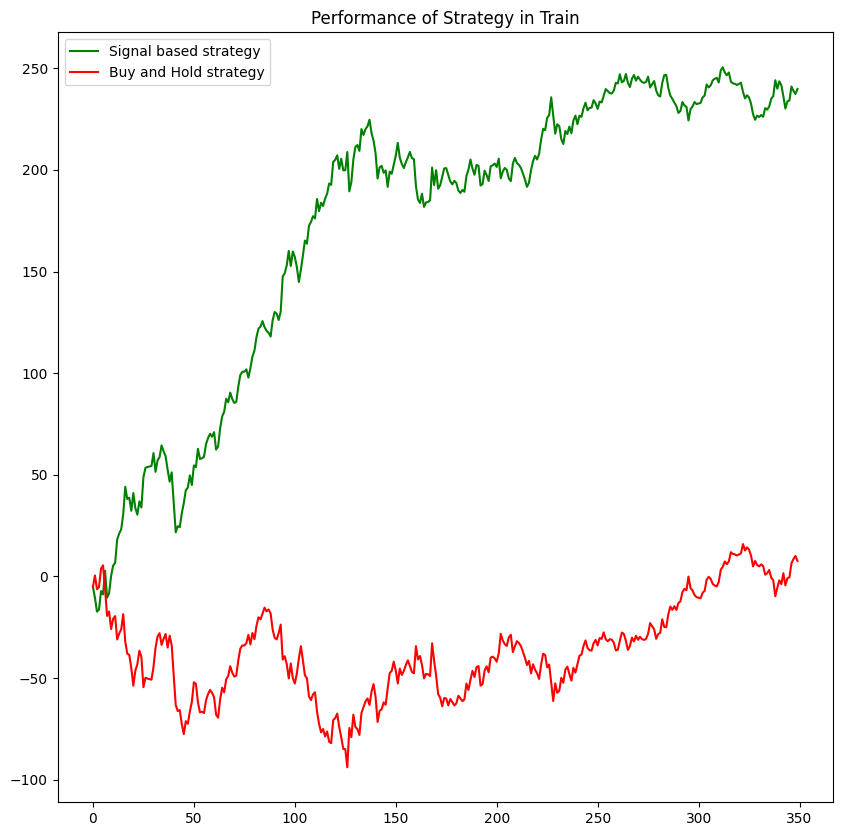

Total profit made in Test:  49.060089111328125


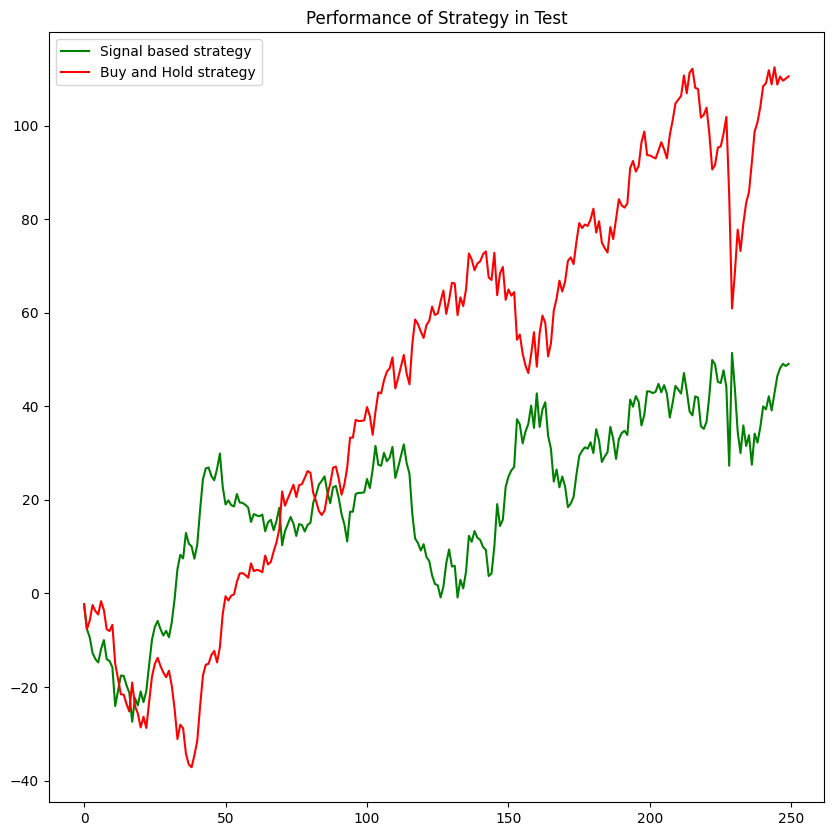

In [49]:
#8 Signal Based strat profits

# Train
Train['Order'] = [1 if sig>0 else -1 for sig in Train['PredictedY']]
Train['Profit'] = Train['spy'] * Train['Order']
Train['Wealth'] = Train['Profit'].cumsum()
print('Total profit made in Train: ', Train['Profit'].sum())

# Plot
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(Train['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Train['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

# Test
Test['Order'] = [1 if sig>0 else -1 for sig in Test['PredictedY']]
Test['Profit'] = Test['spy'] * Test['Order']
Test['Wealth'] = Test['Profit'].cumsum()
print('Total profit made in Test: ', Test['Profit'].sum())

# Plot
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Test')
plt.plot(Test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Test['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

In [50]:
#9 Sharpe Ratio and Maximum Drawdown

Train['Wealth'] = Train['Wealth'] + Train.loc[Train.index[0], 'Price']
Test['Wealth'] = Test['Wealth'] + Test.loc[Test.index[0], 'Price']

# Sharpe Ratio on Train data
Train['Return'] = np.log(Train['Wealth']) - np.log(Train['Wealth'].shift(1))
dailyr = Train['Return'].dropna()
print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

# Sharpe Ratio in Test data
Test['Return'] = np.log(Test['Wealth']) - np.log(Test['Wealth'].shift(1))
dailyr = Test['Return'].dropna()
print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

# Maximum Drawdown in Train data
Train['Peak'] = Train['Wealth'].cummax()
Train['Drawdown'] = (Train['Peak'] - Train['Wealth'])/Train['Peak']
print('Maximum Drawdown in Train is ', Train['Drawdown'].max())

# Maximum Drawdown in Test data
Test['Peak'] = Test['Wealth'].cummax()
Test['Drawdown'] = (Test['Peak'] - Test['Wealth'])/Test['Peak']
print('Maximum Drawdown in Test is ', Test['Drawdown'].max())

Daily Sharpe Ratio is  0.14333318368127695
Yearly Sharpe Ratio is  2.275343751862802
Daily Sharpe Ratio is  0.051597109891744555
Yearly Sharpe Ratio is  0.8190787268593615
Maximum Drawdown in Train is  0.08426248962641132
Maximum Drawdown in Test is  0.06782285410018732
